Description:
The Worldwide Governance Indicators (WGI) project reports aggregate and individual governance indicators for 215 economies over the period 1996–2017, for six dimensions of governance:

Voice and Accountability : perceptions of the extent to which a country's citizens are able to participate in selecting their government, as well as freedom of expression, freedom of association, and a free media.

Political Stability and Absence of Violence : perceptions of the likelihood of political instability and/or politicallymotivated violence, including terrorism.

Government Effectiveness : perceptions of the quality of public services, the quality of the civil service and the degree
of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the
government's commitment to such policies.

Regulatory Quality :  perceptions of the ability of the government to formulate and implement sound policies and regulations that permit and promote private sector development.

Rule of Law :  perceptions of the extent to which agents have confidence in and abide by the rules of society, and in particular thequality of contract enforcement, property rights, the police, and the courts, as well as the likelihood of crime and violence. 

Control of Corruption : perceptions of the extent to which public power is exercised for private gain, including both petty and
grand forms of corruption, as well as "capture" of the state by elites and private interests.

In [4]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white") # change the default seaborn graphics style 
%matplotlib inline

In [10]:
#datas import
# dropna() allows us to delete countries we don't have all the informations
WGI = pandas.read_csv("https://fxjollois.github.io/donnees/WGI/wgi2019.csv").dropna()
WGI

,Country,Code,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
0,Aruba,ABW,1.294189,1.357372,1.029933,0.857360,1.263128,1.217238
1,Andorra,ADO,1.139154,1.615139,1.908749,1.228176,1.579939,1.234392
2,Afghanistan,AFG,-0.988032,-2.649407,-1.463875,-1.120555,-1.713527,-1.401076
3,Angola,AGO,-0.777283,-0.311101,-1.117144,-0.893871,-1.054343,-1.054683
5,Albania,ALB,0.151805,0.118570,-0.061331,0.274380,-0.411179,-0.528758
...,...,...,...,...,...,...,...,...
209,Serbia,SRB,0.026626,-0.091665,0.019079,0.113867,-0.119070,-0.445551
210,South Africa,ZAF,0.670388,-0.217931,0.367380,0.156172,-0.076408,0.084924
211,"Congo, Dem. Rep.",ZAR,-1.365966,-1.808007,-1.627429,-1.509667,-1.786088,-1.538931
212,Zambia,ZMB,-0.286199,-0.102216,-0.675215,-0.554269,-0.462069,-0.640345


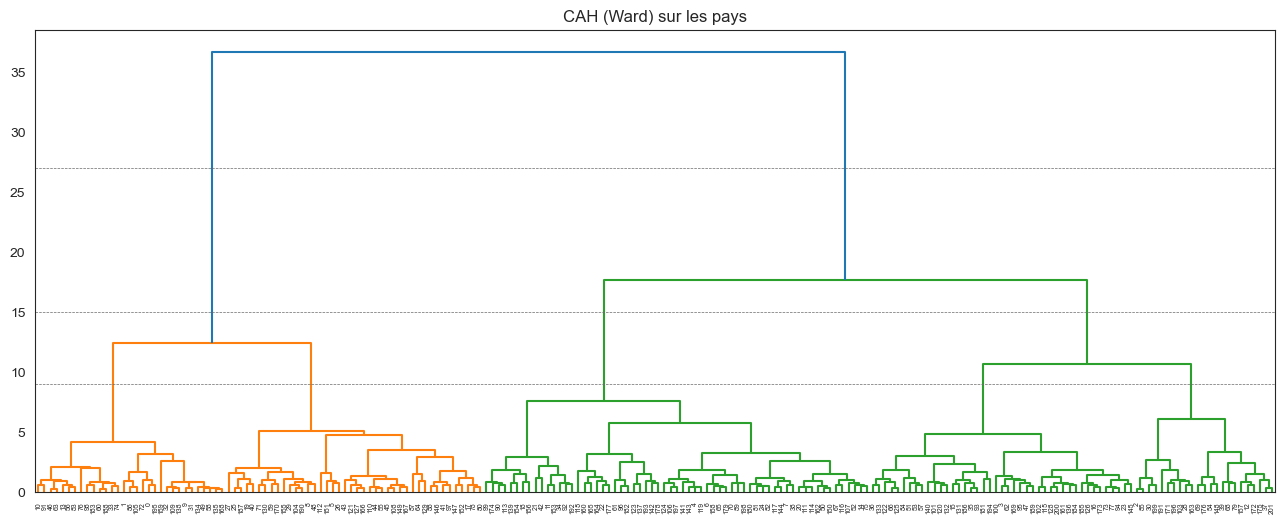

In [54]:
#HAC (hierarchical agglomerative clustering )

from sklearn.cluster import AgglomerativeClustering

WGI_num = WGI.drop(columns = ["Country", "Code"])
#first we don't want to define a number of clusters and we want to keep all the hierarchy
#which means : 0 for distance_threshold and none for n_cluster
hac = AgglomerativeClustering(distance_threshold = 0, n_clusters = None)
hac.fit(WGI_num)


#dendogram
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.figure(figsize = (16, 6))
plt.title("CAH (Ward) sur les pays")
# plot the top three levels of the dendrogram
plot_dendrogram(hac)
plt.axhline(y = 27, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 15, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 9, linewidth = .5, color = "dimgray", linestyle = "--")
plt.show()

It suggests 2 or 3 clusters because there is a big trop between the second and third clusters, and between the third and fourth clusters.
Slighter drop between the fourth and fifth clusters.

In [25]:
#let's try now with 2 clusters
hac2 = AgglomerativeClustering(n_clusters = 2)
hac2.fit(WGI_num)
pandas.DataFrame(hac2.labels_, columns = ["Cluster"]).assign(Count = 1).groupby("Cluster").count()
#give us the repartition of countries between the 2 clusters

,Count
Cluster,
0,129
1,73


In [26]:
WGI_num.assign(Cluster = hac2.labels_).groupby("Cluster").mean()
#means values for each variable and each cluster

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
Cluster,,,,,,
0,-0.498394,-0.536321,-0.615752,-0.603835,-0.633716,-0.641430
1,0.854999,0.824537,1.006136,0.996369,1.032080,1.023469


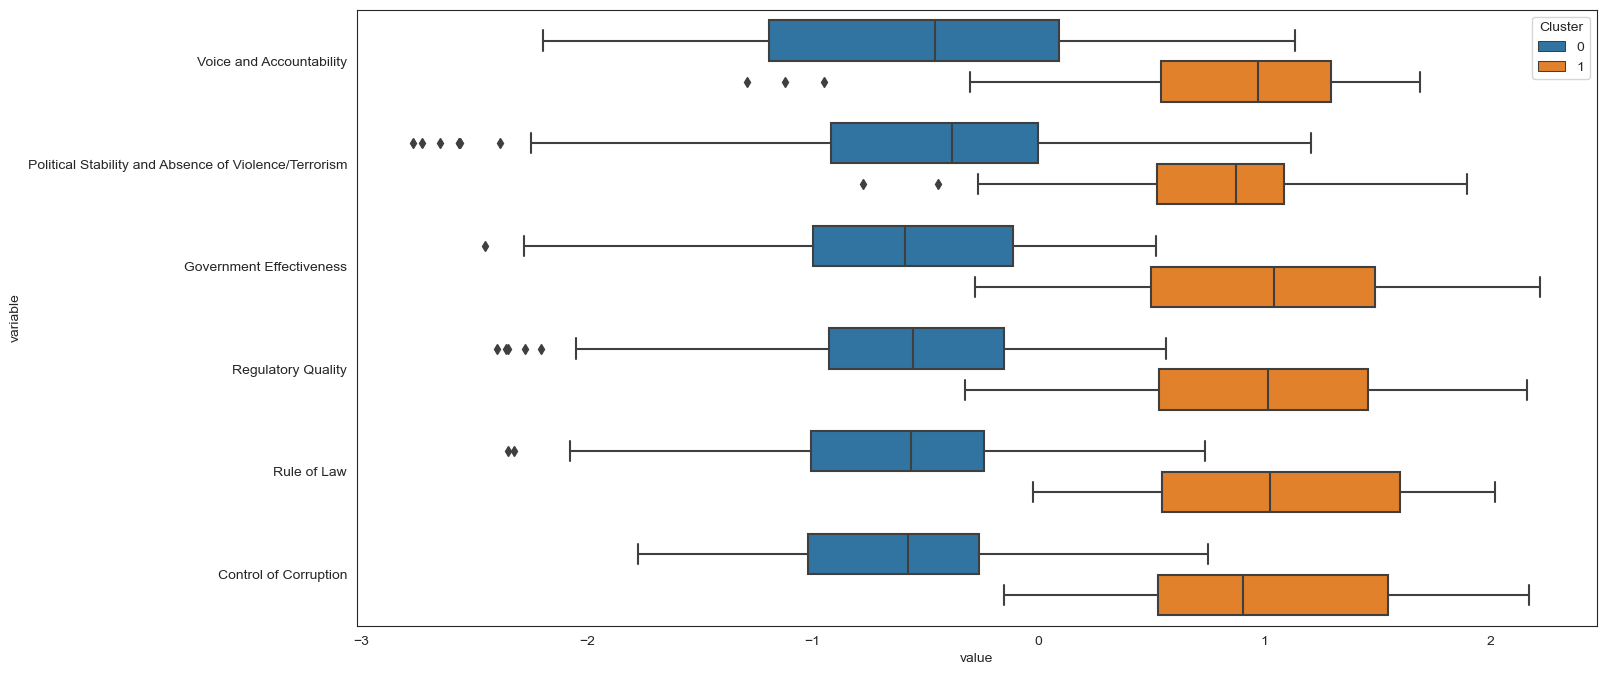

In [19]:
#boxplot for each variable and each cluster
plt.figure(figsize = (16, 8))
df = pandas.melt(WGI_num.assign(Cluster = hac2.labels_), id_vars = 'Cluster')
seaborn.boxplot(data = df, y = "variable", x = "value", hue = "Cluster")
plt.show()

In [31]:
#let's try now with 3 clusters
hac3 = AgglomerativeClustering(n_clusters = 3)
hac3.fit(WGI_num)
pandas.DataFrame(hac3.labels_, columns = ["Cluster"]).assign(Effectif = 1).groupby("Cluster").count()
#give us the repartition of countries between the 3 clusters

,Effectif
Cluster,
0,73
1,66
2,63


In [32]:
WGI_num.assign(Cluster = hac3.labels_).groupby("Cluster").mean()
#means values for each variable and each cluster

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
Cluster,,,,,,
0,0.854999,0.824537,1.006136,0.996369,1.032080,1.023469
1,-0.959242,-1.062068,-1.052668,-0.990906,-1.041426,-1.029118
2,-0.015602,0.014461,-0.158030,-0.198332,-0.206592,-0.235281


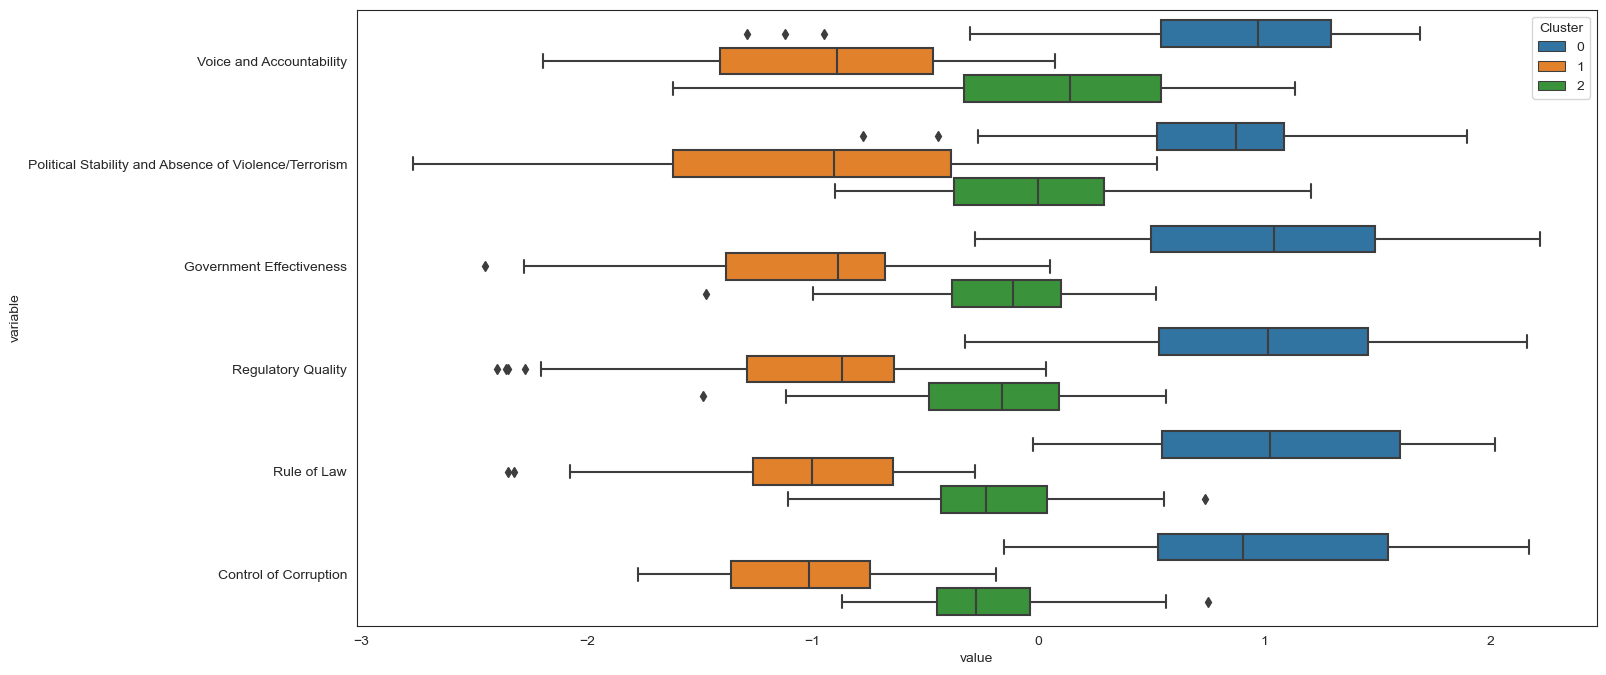

In [23]:
plt.figure(figsize = (16, 8))
df = pandas.melt(WGI_num.assign(Cluster = hac3.labels_), id_vars = 'Cluster')
seaborn.boxplot(data = df, y = "variable", x = "value", hue = "Cluster")
plt.show()
#boxplot for each variable and each cluster

In [27]:
#We can use k-means to decide of the number of clusters
#K-means
#2 clusters
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters = 2)
kmeans2.fit(WGI_num)
#clusters count
pandas.DataFrame(kmeans2.labels_, columns = ["Cluster"]).assign(Count = 1).groupby("Cluster").count()

C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Count
Cluster,
0,120
1,82


In [28]:
#means values for each variable and each cluster
kmeans2.cluster_centers_
WGI_num.assign(Cluster = kmeans2.labels_).groupby("Cluster").mean()

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
Cluster,,,,,,
0,-0.586609,-0.630458,-0.666734,-0.638075,-0.701083,-0.699567
1,0.835551,0.812936,0.902733,0.870845,0.947833,0.925814


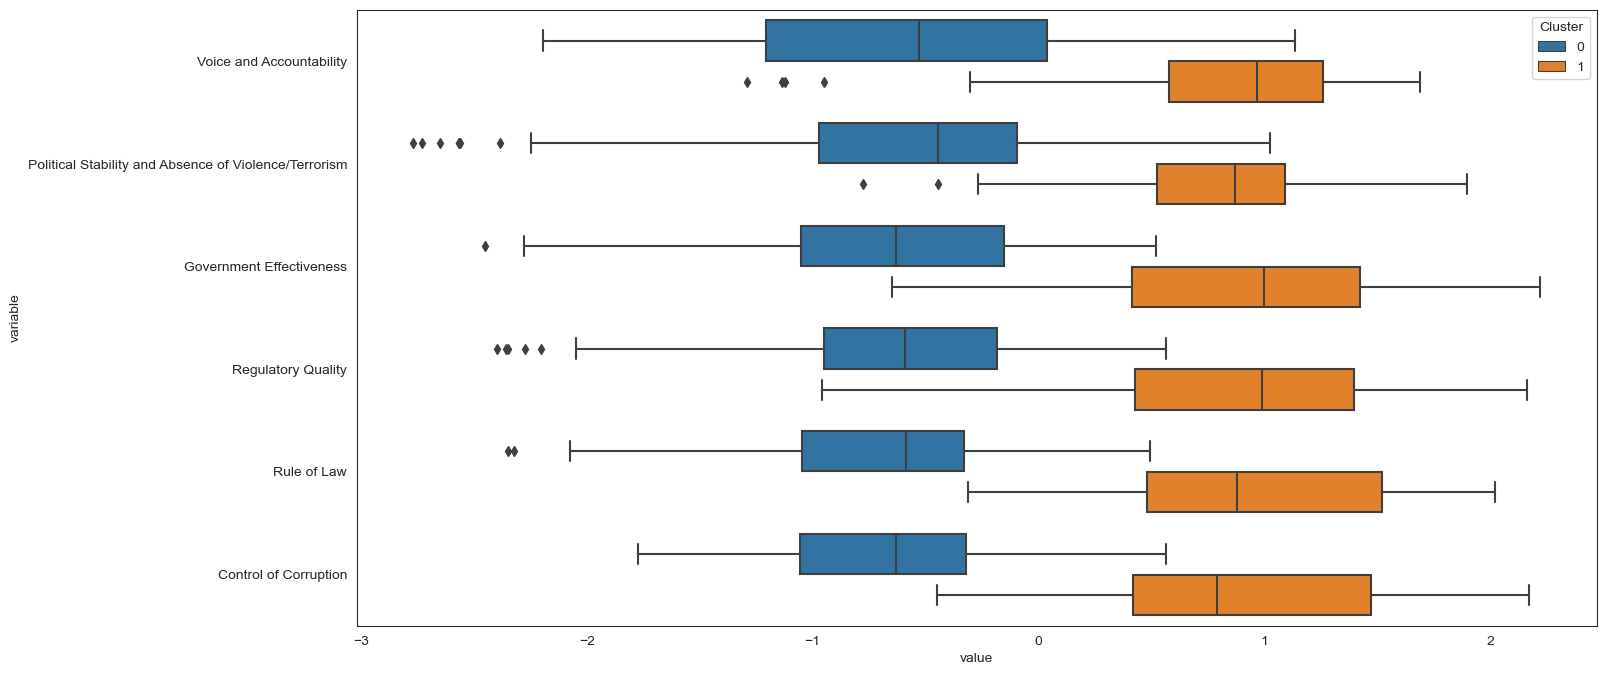

In [29]:
#boxplot for each variable and each cluster
plt.figure(figsize = (16, 8))
df = pandas.melt(WGI_num.assign(Cluster = kmeans2.labels_), id_vars = 'Cluster')
seaborn.boxplot(data = df, y = "variable", x = "value", hue = "Cluster")
plt.show()

In [30]:
#3 clusters
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(WGI_num)
#clusters count
pandas.DataFrame(kmeans3.labels_, columns = ["Cluster"]).assign(Effectif = 1).groupby("Cluster").count()

C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Effectif
Cluster,
0,49
1,66
2,87


In [33]:
#means values for each variable and each cluster
WGI_num.assign(Cluster = kmeans3.labels_).groupby("Cluster").mean()

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
Cluster,,,,,,
0,1.020859,0.889478,1.344081,1.338705,1.327762,1.272946
1,-0.992739,-1.075007,-1.030913,-0.981857,-1.049120,-1.033342
2,0.156560,0.211170,-0.043721,-0.068433,-0.025587,-0.025345


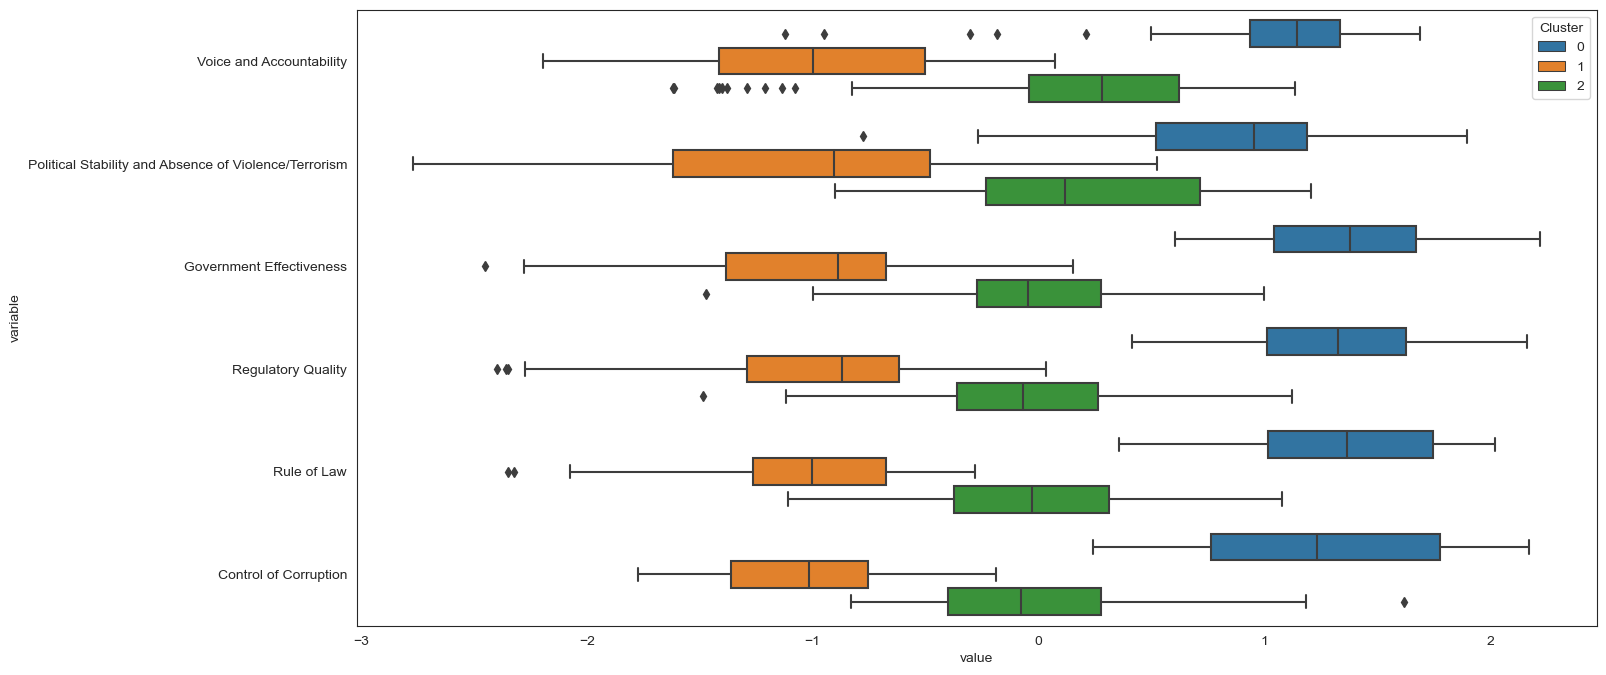

In [34]:
#boxplot for each variable and each cluster
plt.figure(figsize = (16, 8))
df = pandas.melt(WGI_num.assign(Cluster = kmeans3.labels_), id_vars = 'Cluster')
seaborn.boxplot(data = df, y = "variable", x = "value", hue = "Cluster")
plt.show()

C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\33665\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

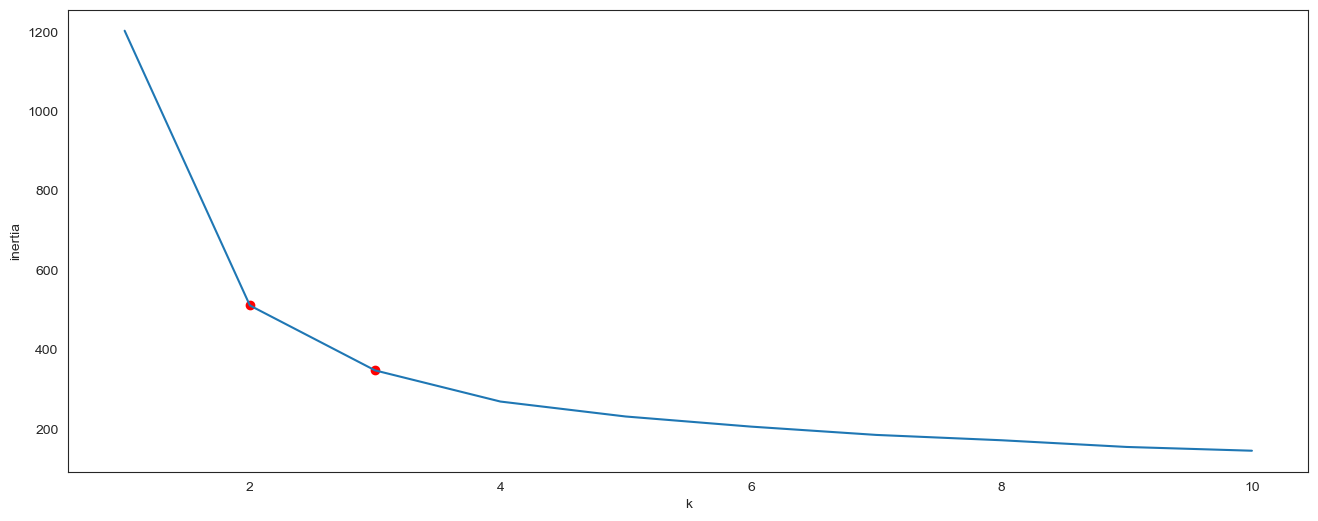

In [37]:
#choice of the number of clusters with k-means
#evolution curve, intra-class inertia which represents the disparities of individuals within the same cluster
plt.figure(figsize = (16, 6))
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(WGI_num)
    inertia = inertia + [kmeans.inertia_]
inertia = pandas.DataFrame({"k": range(1, 11), "inertia": inertia})
seaborn.lineplot(data = inertia, x = "k", y = "inertia")
plt.scatter(2, inertia.query('k == 2')["inertia"], c = "red")
plt.scatter(3, inertia.query('k == 3')["inertia"], c = "red")
plt.show()

We seek the inflection point of this curve
The most striking is the one at 2, it looks better to choose 2 clusters
Even though the one at 3 could also work because there is a break point, slighter than the one at 2

In [ ]:
CLUSTERS REPRESENTATION ON PCA RESULT

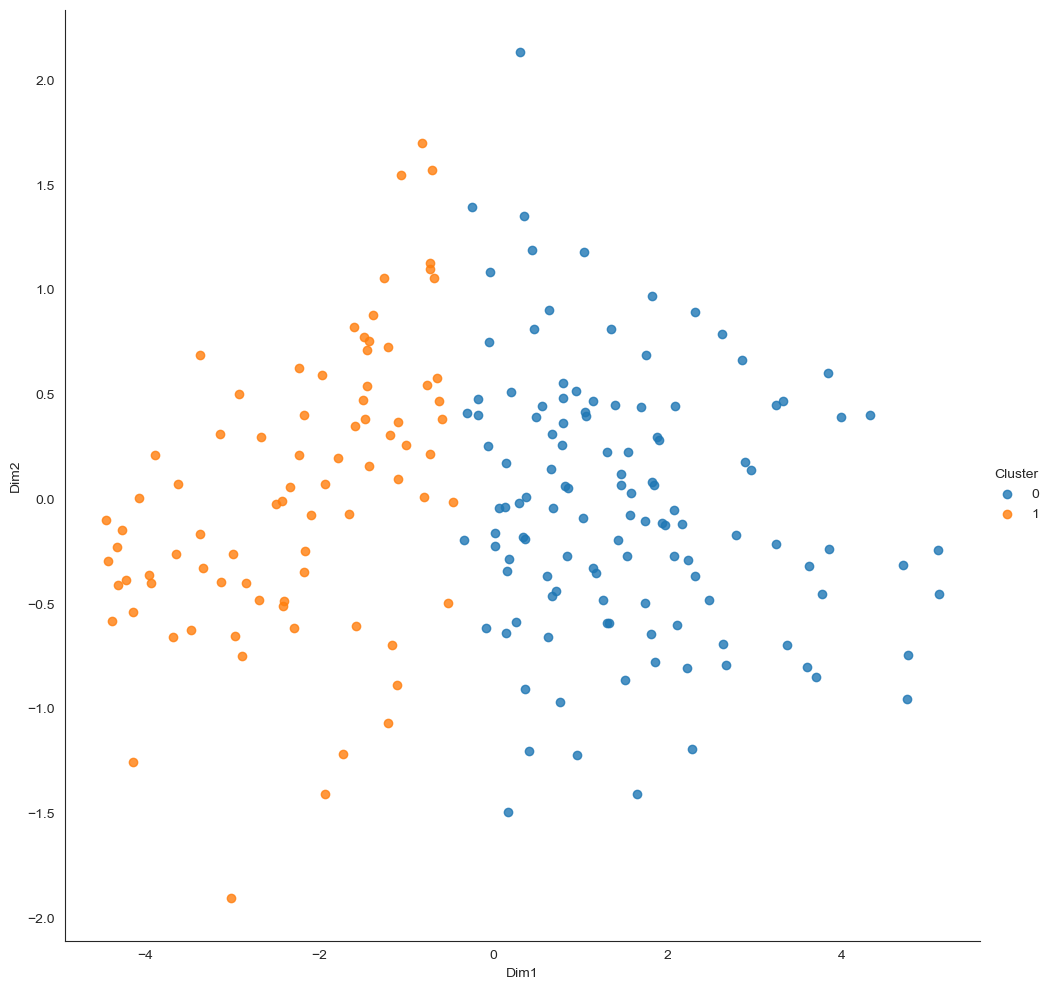

In [57]:
#2 clusters
WGI_numeric = WGI.drop(columns = ["Code","Country"])

from sklearn.decomposition import PCA
pca = PCA().fit(WGI_numeric)
WGI_pca = pca.transform(WGI_numeric)
WGI_pca_df = pandas.DataFrame({
    "Dim1" : WGI_pca[:,0], 
    "Dim2" : WGI_pca[:,1],
    "Country" : WGI["Country"],
    "Cluster" : kmeans2.labels_
})
seaborn.lmplot(data = WGI_pca_df, 
                  x = "Dim1", y = "Dim2", hue = "Cluster",
               fit_reg = False, aspect = 1, height = 10)
plt.show()

Orange observations are countries with a good index, blue with a bad index.

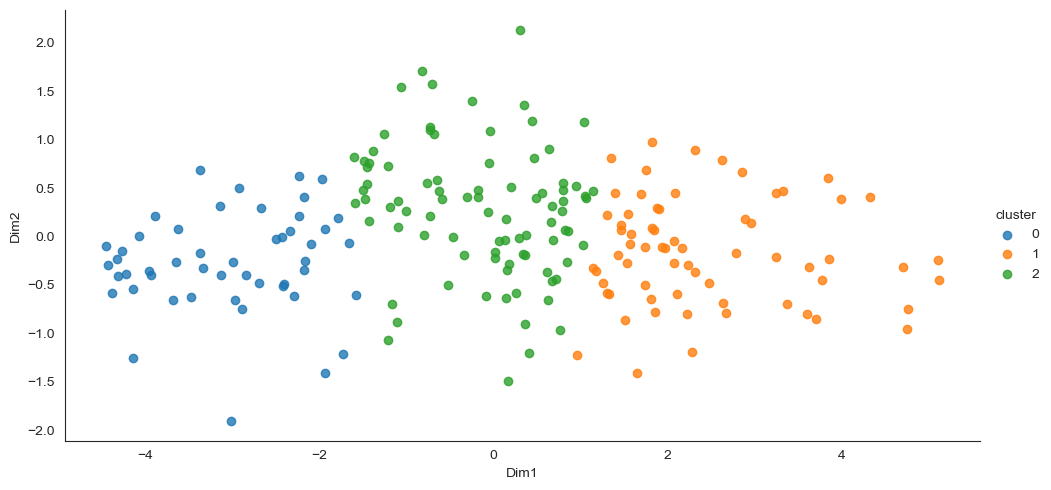

In [55]:
#3 clusters
seaborn.lmplot(data = WGI_pca_df.assign(cluster = kmeans3.labels_), 
               x = "Dim1", y = "Dim2", hue = "cluster", 
               fit_reg = False, height = 5, aspect = 2)
plt.show()

Blue observations are countries with a bad index, green with an avarage index and orange with a bad index.